# PSM3 Pixel Boundaries

The PSM3 provides data with a nominal 2 km spatial resolution, at least according to the NSRDB [website](https://nsrdb.nrel.gov/data-sets/us-data).  I am interested in what the real underlying data grid actually looks like; this notebook shows that the real grid is defined by angular extent (regular in latitude/longitude), not spatial extent.

In [1]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Before getting started -- querying 5-minute PSM3 data is a bit slow, and likely I'll want to re-run cells here as I tweak the notebook, so let's cache the requests to speed things up.

In [2]:
from functools import lru_cache

@lru_cache(maxsize=512)
def get_psm3(lat, lon):
    api_key = 'redacted'
    email = 'redacted'
    return pvlib.iotools.get_psm3(lat, lon, api_key, email, names=2020, interval=5,
                                  attributes=('ghi',), leap_day=True, map_variables=True)

First, take note that the API returns the coordinates of the queries pixel.  I don't think this is documented anywhere, but I think these coordinates represent the middle of the pixel.

In [3]:
df, meta = get_psm3(40, -80)
meta['latitude'], meta['longitude']

(40.0, -80.01)

From previous experience I have a hunch that the grid spacing is 0.02° in both latitude and longitude.  So let's query just inside the corners of that grid and see what happens:

In [4]:
def get_corners(center, spacing=0.02, buffer=0.001):
    delta = spacing / 2 - buffer
    return [
        (center[0] - delta, center[1] - delta),
        (center[0] - delta, center[1] + delta),
        (center[0] + delta, center[1] + delta),
        (center[0] + delta, center[1] - delta),
    ]

center_lats =  40.00 + np.arange(-1, 2) * 0.02
center_lons = -80.01 + np.arange(-1, 2) * 0.02

data = []

for center_lat in center_lats:
    for center_lon in center_lons:
        for lat, lon in get_corners([center_lat, center_lon]):
            df, meta = get_psm3(lat, lon)
            data.append({'lat': lat, 'lon': lon, 'ghi': df['ghi'].sum() / 12})

out = pd.DataFrame(data)

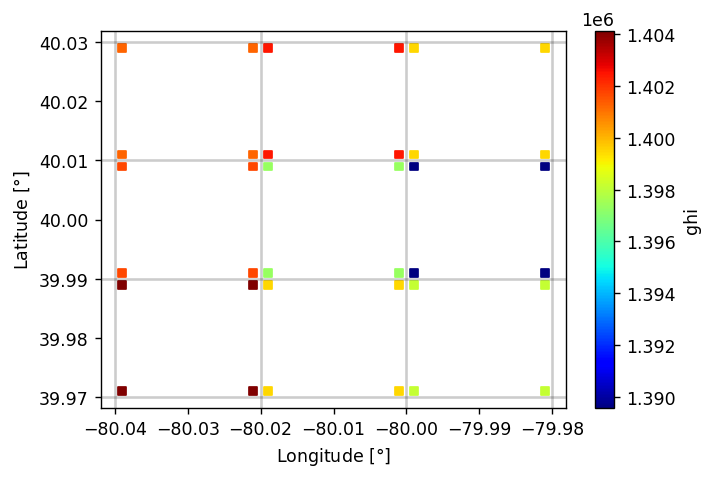

In [5]:
fig, ax = plt.subplots(dpi=125)
out.plot.scatter('lon', 'lat', c='ghi', marker='s', ax=ax, cmap='jet')
ax.set_xlabel(r'Longitude [$\degree$]')
ax.set_ylabel(r'Latitude [$\degree$]')
for grid_lat in list(center_lats + 0.01) + [center_lats[0] - 0.01]:
    plt.axhline(grid_lat, c='k', alpha=0.2)
for grid_lon in list(center_lons + 0.01) + [center_lons[0] - 0.01]:
    plt.axvline(grid_lon, c='k', alpha=0.2)

So indeed GHI values seem constant within each 0.02° by 0.02° rectangle, at least for this location.  Although note that the pixels are aligned a little strangely -- the boundaries are on even hundredths of degrees in longitude but odd hundredths in latitude. 

Let's verify that we get the same results at a different location:

In [6]:
center_lats =  46.50 + np.arange(-1, 2) * 0.02
center_lons = -85.29 + np.arange(-1, 2) * 0.02

data = []

for center_lat in center_lats:
    for center_lon in center_lons:
        for lat, lon in get_corners([center_lat, center_lon]):
            df, meta = get_psm3(lat, lon)
            data.append({'lat': lat, 'lon': lon, 'ghi': df['ghi'].sum() / 12})

out = pd.DataFrame(data)

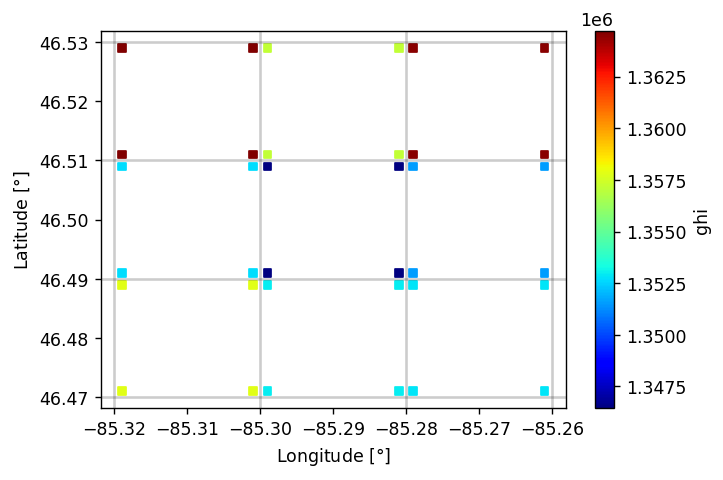

In [7]:
fig, ax = plt.subplots(dpi=125)
out.plot.scatter('lon', 'lat', c='ghi', marker='s', ax=ax, cmap='jet')
ax.set_xlabel(r'Longitude [$\degree$]')
ax.set_ylabel(r'Latitude [$\degree$]')
for grid_lat in list(center_lats + 0.01) + [center_lats[0] - 0.01]:
    plt.axhline(grid_lat, c='k', alpha=0.2)
for grid_lon in list(center_lons + 0.01) + [center_lons[0] - 0.01]:
    plt.axvline(grid_lon, c='k', alpha=0.2)

We do!  So indeed the grid seems regular in angular coordinates, not spatial coordinates.  But if the grid is regular in angular coordinates, that means that pixels become increasingly distorted towards the poles (same height/latitude extent, thinner width/longitude extent).  How much do the pixel footprints and shapes change over the latitudes relevant in the US?

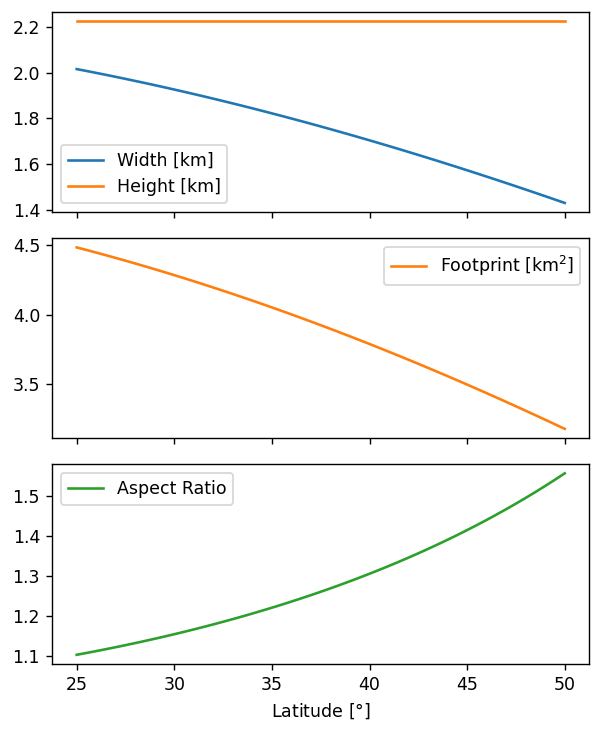

In [8]:
import haversine

lats = np.linspace(25, 50)
# pixels are small enough to approximate as rectangles:
widths = np.array([haversine.haversine((lat, -80.02), (lat, -80.00)) for lat in lats])
heights = np.array([haversine.haversine((lat - 0.01, -80.01), (lat + 0.01, -80.01)) for lat in lats])

out = pd.DataFrame({
    r'Width [km]': widths,
    'Footprint [km$^2$]': widths * heights,
    'Aspect Ratio': heights / widths,
}, index=lats)
out.index.name = r'Latitude [$\degree$]'

axes = out.plot(subplots=True, figsize=(5, 6))
axes[0].plot(lats, heights, label='Height [km]', c='tab:orange')
axes[0].legend()
plt.gcf().set_dpi(125)
plt.gcf().tight_layout()